#### Reinforcement Learning with BlueSky
In this Jupyter Notebook we will look at how to use Bluesky for a simple Reinforcement Learning task. The task at hand will be for the model to predict when to initialize the top of descent while being constraint to the dynamics of the aircraft model.

Lets start by importing the relevant modules:

In [1]:
import numpy as np

import bluesky as bs
from bluesky.simulation import ScreenIO

#The Soft Actor Critic Class used for the Deep Reinforcement Learning part of this notebook
from SAC.sac_agent import SAC

#Import the functions used during the Reinforcement Learning
from functions import reset_env, do_action, get_update, get_reward, get_state

Using Python-based geo functions


We create a dummy class that acts as the screen of BlueSky. Since we don't want to actually load the screen from BlueSky here, a simple and small class is used instead to avoid errors when something within BlueSky is calling the echo function.

In [2]:
class ScreenDummy(ScreenIO):
    """
    Dummy class for the screen. Inherits from ScreenIO to make sure all the
    necessary methods are there. This class is there to reimplement the echo
    method so that console messages are printed.
    """
    def echo(self, text='', flags=0):
        """Just print echo messages"""
        print("BlueSky console:", text)

The first step to take is to initialise bluesky (here imported as bs) as a disconnected, single simulation. Next we replace the screen object with our derived variant so that bluesky console messages are printed.

In [3]:
# initialize bluesky as non-networked simulation node

bs.init(mode='sim', detached=True)

# initialize dummy screen
bs.scr = ScreenDummy()

Reading config from C:\Users\Jan\bluesky\settings.cfg
Reading magnetic variation data
Loading global navigation database...
Reading cache: C:/Users/Jan/bluesky/data/cache\py3\navdata.p
Failed to load OpenAP performance model
Failed to load BADA performance model
Successfully loaded plugin AREA
Successfully loaded plugin DATAFEED


#### Functions

To allow reinforcement learning to be incorporated with Bluesky, we need to make some additional functions that create the bridge between the reinforcement learning algorithm and Bluesky. These functions are:

* reset_env() -> state_
* get_state() -> state_
* get_reward(state_) -> reward, done
* get_update() -> state_, reward, done
* do_action(action) -> None

In these functions only 'state_' is used, which refers to the most recent state information. The RL model also takes 'state' as an input for the memory buffer to allow proper learning of the state transition and therefore Critic functions. This 'state' variable refers to the state preceding 'state_'. 


reset_env() -> state_

In [3]:
"""
reset_env() removes the previous aircraft from the simulation. In principle only one aircraft
should exist, but loops through all aircraft in this example. Then creates a new aircraft.
"""
def reset_env():

    for acid in bs.traf.id:
        idx = bs.traf.id2idx(acid)
        bs.traf.delete(idx)

    bs.traf.cre('KL001',actype="A320",acalt=3000,acspd=150)

    return get_state()

do_action(action)

In [ ]:
"""
do_action(action) takes the output of the RL model and translates it to an action intepretable 
by Blueksy. As the output of the RL model is -1 < action < 1, we first map it to sensible values.
Then the action is executed through stack commands in the Bluesky simulator.
"""
def do_action(action):
    # Transform action to the feet per minute domain
    action = action * 2500

    # Get aircraft ID of the controlled aircraft
    acid = bs.traf.id[0]

    # Bluesky interpretes vertical velocity command through altitude commands 
    # with a vertical speed (magnitude). So check sign of action and give arbitrary 
    # altitude command
    if -250<action<250:
        bs.stack.stack(f'ALT {acid},{bs.traf.alt[0]},{250}')
    if action > 0:
        bs.stack.stack(f'ALT {acid},45000,{action}')
    if action < 0:
        bs.stack.stack(f'ALT {acid},0,{-action}')


get_state() -> state_

In [ ]:
"""
get_state() accesses the traffic arrays of Bluesky to create and return a state for the aircraft.
In this case only 1 aircraft is used, so aircraft ID index == 0, but with multiple agents get_state()
should require the aircraft ID index as input to access the correct state info.
"""
def get_state():
    # get current altitude, vertical speed and distance to the runway (set at 200km from origin)
    alt = bs.traf.alt[0]
    vs = bs.traf.vs[0]
    dis =(200 - bs.tools.geo.kwikdist(52,4,bs.traf.lat[0],bs.traf.lon[0])*1.852)

    # (roughly) normalize the state values to a mean of zero and variance 1
    # (for more complex environments its better to calculate the mean and std over 
    # a series of interactions with the environment)
    alt = (alt - 1500)/3000
    vs = vs / 5
    dis = (dis - 100)/200

    state = [alt,vs,dis]

    return state

get_reward(state_) -> reward, done

In [ ]:
"""
get_reward(state) uses the (new) state variable to calculate a corresponding reward.
In principle the designed reward function will control the behaviour of the model after convergence,
so reward function design should be done with care. 
If a model does not do what you want, maybe this function is not stimulating the appropriate behaviour.
"""
def get_reward(state):
    # denormalize the relevant state variables
    alt = (state[0]*3000)+1500
    dis = (state[2]*200)+100

    # reward part of the function
    if dis > 0 and alt> 0:
        return abs(3000-alt)*-5/3000, 0
    elif alt <= 0:
        return -10, 1
    elif dis <= 0:
        return abs(100-alt)*-20/3000, 1

get_update() -> state_, reward, done

In [ ]:
"""
get_update() returns the values from get_state() and get_reward(state) for the new simulation step in 
a single function. 
"""
def get_update():
    state_ = get_state()
    reward, done = get_reward(state_)
    return state_,reward,done

##### Visualizing the Reward Function in a Heatmap
To visualize what the behavior of a properly trained model should look like, we visualize the space of the reward function in a heatmap.

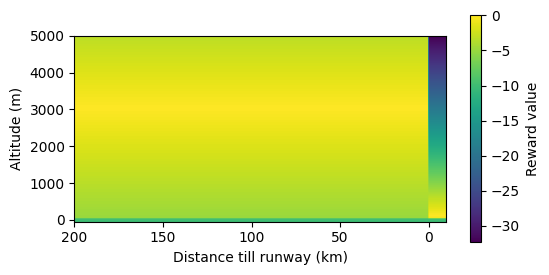

In [11]:
#heatmap of the reward function
import matplotlib.pyplot as plt

# Generate the array of all x and y state pairs for which we want to visualize the reward
# Note that because the RL model works with normalized state data, we normalize the x and y data
xarray = np.flip(np.arange(-10,210,1))
yarray = np.flip(np.arange(-50,5000,50))

xnorm = (xarray-100)/200
ynorm = (yarray-1500)/3000

reward_map = np.zeros((len(ynorm),len(xnorm)))

for i in range(len(xnorm)):
    for j in range(len(ynorm)):
        # get reward requires the state as an input, which contains also the vertical speed.
        # for now just set that at zero.
        state = [ynorm[j],0,xnorm[i]]
        reward_map[j,i], _ = get_reward(state) # Returns a scalar reward, and a done flag
        
fig, ax = plt.subplots(figsize=(6, 3), dpi=100)
figure = ax.imshow(reward_map, extent=[200,-10,-50,5000])

cbar = plt.colorbar(figure)
cbar.set_label('Reward value')
im = ax.get_images()
extent =  im[0].get_extent()
ax.set_xlabel('Distance till runway (km)')
ax.set_ylabel('Altitude (m)')
ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/2)

plt.show()

As you can see in the image, the reward map gives a penalty for premature landings and for being to high when the distance to runway is equal to zero.
furthermore, the lowest penalty is given for flying a level flight at 3000m altitude for as long as possible.

The expected behavior of a properly trained model is therefore to see it staying at 3000m for as long as possible before steeply descending to minimize the penalty at D = 0. 

#### Training the model:

The next step is to train the model within bluesky, subjected to this reward function. 

To speed up the training the simulation timestep is set to 1 second and fastforward is activated through the stack command "bs.stack.stack('DT 1; FF)"




In [4]:
bs.stack.stack('DT 1;FF')

N_episodes = 1000 # how many episodes should the model train
Rewards = np.zeros(N_episodes)

action_frequency = 30 # how often should the RL model select an action for the aircraft (default once every 30 seconds)

action_dim = 1
state_dim = 3
agent = SAC(action_dim,state_dim)

alt = [[]]*N_episodes
dist = [[]]*N_episodes

for episode in range(N_episodes):
    #initialise episode
    done = 0
    state = reset_env()
    total_reward = 0

    temp_alt = np.array([])
    temp_dist = np.array([])
    while not done:

        action = agent.step(state)
        do_action(action[0][0])

        # Progress the simulation 
        for i in range(action_frequency):
            bs.sim.step()
        
        # Get the information regarding the new environment state
        state_, reward, done = get_update(state)

        # Store the state transition and preform a training update
        agent.store_transition(state,state_,reward,action[0][0],done)
        agent.train()

        # set the old state to the new state
        state = state_

        # Save relevant information for plotting purposes
        total_reward += reward
        temp_alt = np.append(temp_alt,(state[0]*3000)+1500)
        temp_dist = np.append(temp_dist,(state[2]*200)+100)

    alt[episode] = temp_alt
    dist[episode] = temp_dist
    Rewards[episode] = total_reward

    # Some printing to see if the reward is increasing, e.g. is the model learning
    if episode % 100 == 0:
        print(np.mean(Rewards[0:episode]))

DEVICE USED <torch.cuda.device object at 0x00000284F620D1B0> Quadro P2000
BlueSky console: Base dt set to 1.0
performance dt is unchanged.
asas dt is unchanged.
AREA dt is unchanged.
DATAFEED.update dt set to 1.0 to match integer multiple of base dt.


c:\Users\Jan\Anaconda3\envs\BSRLnotebook\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Jan\Anaconda3\envs\BSRLnotebook\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan
-177.2199084945
-126.77108623108336
-110.7987651052778
-95.10422728316667
-83.258329048
-74.72666273419443
-68.11839767661907
-63.011062022270835
-59.125399426092606
-55.91806374238334
-53.322223103090906
-51.04310477761111
-49.216469511
-47.60028493141667
-46.1259693647
-44.779797377260415
-43.52071743665687
-42.45333175998149
-41.463474974421054
-40.53661219172499
-39.70053748822222
-38.91006605618182
-38.18597110750724
-37.5120322846875
-36.865173974473336
-36.26627103937179
-35.71038264574074
-35.1507899994881
-34.63642735579885
-34.15290202562778
-33.67677743398388
-33.23207621580729
-32.80086925859091
-32.39040216070098
-31.987339439833335
-31.613907090847224
-31.251787147842343
-30.911328726267545
-30.58170379208974
-30.266021690141667
-29.967826721105684
-29.68536783315476
-29.405802824724802
-29.143551260799242
-28.896115284259256
-28.662568592507245
-28.436091177390068
-28.223307920378474
-28.024761355013602
-27.824238959996666
-27.636099402166668
-27.44437847996474
-27.2

### Plotting after Training

#### Plotting the Trajectories

In [1]:
import matplotlib.pyplot as plt
from PIL import Image

did_training = False

if did_training:
    fig, ax = plt.subplots(1, 1)
    ax.plot(dist[9],alt[9], label='initial (random) behaviour')
    ax.plot(dist[99],alt[99], label='policy after 100 episodes')
    ax.plot(dist[999],alt[999], label='policy after 1000 episodes')
    ax.legend()
    ax.invert_xaxis()
    plt.show()
else:
    fig = Image.open('figures/TrajectoryEvolution.png')
    fig.show()

#### Plotting the rewards

In [2]:
did_training = False

if did_training:
    fig, ax = plt.subplots(1, 1)
    ax.plot(Rewards)
    ax.set_xlabel('Episode Number')
    ax.set_ylabel('Obtained Reward')
    plt.show()
else:
    fig = Image.open('figures/RewardEvolution.png')
    fig.show()
